# The Zero Order Hold trajectory leg

The Zero Order Hold (ZOH) trajectory leg is implemented in `pykep` in the class {class}`pykep.leg.zoh`. Extending the class {class}`pykep.leg.sims_flanagan`, this leg accounts for a continuous thrust considered fixed in some frame along each segment of predefined length, as well as for a generic dynamics and variable segment lengths.

Thus, it approximates a thrust strategy via a sequence of continuous, constant thrust arcs (zero order hold). The leg is defined by a starting state $\mathbf x_0 = [\mathbf r_0, \mathbf v_0, m_0]$, a final state $\mathbf x_1 = [\mathbf r_1, \mathbf v_1, m_1]$ and a time grid defining the various segment lengths.

A sequence of controls $\mathbf u = [T_0, i_{x0}, i_{y0}, i_{z0}, T_1, i_{x1}, i_{y1}, i_{z1}, T_2, i_{x2}, i_{y2}, i_{z2}, ... ]$ define the magnitude and direction of the continuous thrust vector along each segment.

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.zoh`.

We start with some imports:

In [1]:
import pykep as pk
import heyoka as hy
import numpy as np
import pygmo as pg
from copy import deepcopy

#%matplotlib ipympl
%matplotlib inline

In [2]:
# Tolerances used in the numerical integration
# Low tolerances result in higher speed (the needed tolerance depends on the orbital regime)
tol=1e-10
tol_var = 1e-6

# We instantiate ZOH Taylor integrators for Keplerian dynamics, shipped in pykep.
ta_global = pk.ta.get_zoh_kep(tol)
ta_var_global = pk.ta.get_zoh_kep_var(tol_var)

# nd units (remember that the ZOH taylor integrator is using non dimensional units expecting MU=1)
L = pk.AU
MU = pk.MU_SUN
TIME = np.sqrt(L**3/MU)
V =  L/TIME
ACC = V/TIME
MASS = 1000
F = MASS*ACC

# 1 - Test the zero hold leg
We compute the gradient of the mismatch and throttle constraints numerically and using the analytical ones provided by {class}`pykep.leg.zoh`. We check that they are indeed the same,
and in the process we learn how to instantiate and use the class.

We need a small helper to get the numerical gradients easily:

In [3]:
# These assume some copy of the leg as they will modify it.
def compute_mismatch_constraints_n(leg_mod, state0, controls, state1, tgrid):
   leg_mod.tgrid = tgrid
   leg_mod.state0 = state0
   leg_mod.state1 = state1
   leg_mod.controls = controls
   leg_mod.state1 = state1
   return leg_mod.compute_mismatch_constraints()

def compute_throttle_constraints_n(leg_mod, controls):
    leg_mod.controls = controls
    return leg_mod.compute_throttle_constraints()

We are now ready to instantiate the leg. We do so by randomly selecting the number of segments, the cut, the effective exhaust velocity, the controls and initializing the remaining quantities.

To obtain meaningful initial and final states, we compute a Lambert transfer between two Solar System planets. This choice is not essential to the method and is only meant to provide a physically plausible example.

In [4]:
# Create a Lambert leg 
t0 = 10000
t1 = 10400
pl0 = pk.planet(pk.udpla.jpl_lp("Earth"))
pl1 = pk.planet(pk.udpla.jpl_lp("Mars"))
r0, v0 = pl0.eph(t0)
r1, v1 = pl1.eph(t1)
# We create some starting conditions from a Lambert arc
l = pk.lambert_problem(r0=r0, r1=r1, tof = (t1-t0) * pk.DAY2SEC, mu = pk.MU_SUN)
m0 = 1000
m1 = 1000

# leg random data
nseg = int(np.random.uniform(4, 20))
veff = np.random.uniform(4000, 8000) * pk.G0
controls = np.random.uniform(-1,1, (4*nseg,))
controls[0::4] /= (F)  # force will be in [-1, 1] N
controls[0::4] = np.abs(controls[0::4]) # force will be in [0.s, 1] N
cut = np.random.uniform(0,1)

# putting all in nd units
state0 = [it/L for it in r0] + [it/V for it in l.v0[0]] + [m0/MASS]
state1 = [it/L for it in r1] + [it/V for it in l.v1[0]] + [m1/MASS]
veff_nd = veff / V
tgrid = np.linspace(t0*pk.DAY2SEC/TIME, t1*pk.DAY2SEC/TIME, nseg+1)

# Setting the integrator parameters
ta_global.pars[4] = 1. / veff_nd
ta_var_global.pars[4] = 1. / veff_nd

# Instantiate the leg
leg = pk.leg.zoh(state0, controls.tolist(), state1, tgrid, cut = cut, tas = [ta_global, ta_var_global])

We now compute and store the analytical gradient.

In [5]:
grad_an_mc = leg.compute_mc_grad()
tcgrad_an_tc = leg.compute_tc_grad()

... and check with the numerically computed one. We compute the numerical gradient using `pagmo` provided routine.

In [6]:
# Check on dmc/dx0
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, x, leg_copy.controls, leg_copy.state1, leg_copy.tgrid), leg.state0).reshape(7,-1)
np.linalg.norm(grad_num-grad_an_mc[0])

6.3654855997739736e-08

In [7]:
# Chack on dmc/dxf
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, leg_copy.controls, x, leg_copy.tgrid), leg.state1).reshape(7,-1)
np.linalg.norm(grad_num-grad_an_mc[1])

3.7716993235692714e-06

In [8]:
# Chack on dmc/dcontrols
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, x, leg_copy.state1, leg_copy.tgrid), leg.controls, dx=1e-8).reshape(7,-1)
np.linalg.norm(grad_num-grad_an_mc[2])

2.3246825123311366e-06

In [9]:
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_mismatch_constraints_n(leg_copy, leg_copy.state0, leg_copy.controls, leg_copy.state1, x), leg.tgrid).reshape(7,-1)
np.linalg.norm(grad_num-grad_an_mc[3])

5.0101951528861315e-07

In [10]:
leg_copy = deepcopy(leg)
grad_num = pg.estimate_gradient(lambda x: compute_throttle_constraints_n(leg_copy, x), leg.controls).reshape(nseg,-1)
np.linalg.norm(grad_num-tcgrad_an_tc)

2.4161027131804172e-08

So ... those are small differences, compatible with the numercial gradient low precision (the analytical gradient will be better, and can be made as accurate as needed controlling the precision of the Taylor adaptive integrator)

We can even plot the leg, in this case overlaying it with pykep planets.

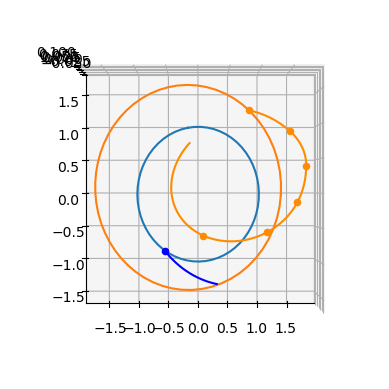

In [11]:
ax = pk.plot.make_3Daxis()
pk.plot.add_planet_orbit(ax, pl0, units=pk.AU)
pk.plot.add_planet_orbit(ax, pl1, units=pk.AU)
fwd, bck = leg.get_state_info(N=100)
for segment in fwd:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'blue') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'blue') 
for segment in bck:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'darkorange') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'darkorange') 

ax.view_init(90,-90)


# 2 - Use with arbitrary dynamics

One of the very, and I mean very, cool things in {class}`pykep.leg.zoh` is the possibility to use arbitrary dynamics. One can then have a leg in the CR3BP, as well as the equinoctial parameter dynamics for Keplerian motion, or a full ephemerides model of N-Body dynamics, and so on..... 

The requirements for a dynamics to be usable in {class}`pykep.leg.zoh` are:

* The state dimension must be 7 (typically *pos*, *vel* and *mass*, but not necessarily)
* The `heyoka` parameters used in the dynamics must include at least and in this order: hy.par[0] -> $T$, hy.par[1] -> $i_x$, hy.par[2] -> $i_y$, hy.par[3] -> $i_z$ 
* The variational state dimension must be 84 (corresponding to 7 equations for 7 state and 4 parameters 7 + 7*7 + 7*4). The four parameters must be hy.par[0] .. hy.par[3].

In `Pykep` several dynamics are already written which satisfy the above requirements: {class}`pykep.ta.zoh_kep`, {class}`pykep.ta.zoh_eq`, {class}`pykep.ta.zoh_cr3bp` and thus can
be readily used.

In the following we will, instead, explicitly define a ZOH dynamics for the cr3bp, with the understanding that we could have insted used directly {class}`pykep.ta.zoh_cr3bp`.


In [12]:
# The symbolic variables.
[x, y, z, vx, vy, vz, m] = hy.make_vars("x", "y", "z", "vx", "vy", "vz", "m")

# Naming the system controls
T_norm = hy.par[0]
i_x, i_y, i_z = hy.par[1], hy.par[2], hy.par[3]

# Naming the system parametes
c = hy.par[4]  # 1/veff
mu = hy.par[5]

# Distances to the bodies.
r_1 = hy.sqrt(hy.sum([pow(x + mu, 2.0), pow(y, 2.0), pow(z, 2.0)]))
r_2 = hy.sqrt(hy.sum([pow(x - (1.0 - mu), 2.0), pow(y, 2.0), pow(z, 2.0)]))

# The Equations of Motion.
xdot = vx
ydot = vy
zdot = vz
vxdot = (
    2.0 * vy
    + x
    - (1.0 - mu) * (x + mu) / pow(r_1, 3.0)
    - mu * (x + mu - 1.0) / pow(r_2, 3.0)
    + T_norm * i_x / m
)
vydot = (
    -2.0 * vx
    + y
    - (1.0 - mu) * y / pow(r_1, 3.0)
    - mu * y / pow(r_2, 3.0)
    + T_norm * i_y / m
)
vzdot = -(1.0 - mu) * z / pow(r_1, 3.0) - mu * z / pow(r_2, 3.0) + T_norm * i_z / m
mdot = (
    -c * T_norm * hy.exp(-1.0 / m / 1e16)
)  # the added term regularizes the dynamics keeping it differentiable

dyn = [
    (x, xdot),
    (y, ydot),
    (z, zdot),
    (vx, vxdot),
    (vy, vydot),
    (vz, vzdot),
    (m, mdot),
]

ta_cr3bp = hy.taylor_adaptive(dyn, tol=tol, pars=[0.0, 0.0, 0.0, 0.0, 0.0, 0.01])
vsys = hy.var_ode_sys(
    dyn,
    [x, y, z, vx, vy, vz, m, hy.par[0], hy.par[1], hy.par[2], hy.par[3]],
    1,
)
ta_cr3bp_var = hy.taylor_adaptive(
    vsys,
    tol=tol,
    compact_mode=True,
)


Note how we wrote the usual CR3BP dynamics, adding some external thrust force and a corresponding (regularized) mass equation. To respect the ZOH requirements on the dynamics we reserved the first four parameters for the differetiable thrust description, and thus used `par[4]` and `par[5]` to store $I_{sp}g_0$ and $\mu$.

Let us start simulating in this dynamics (always a good check) a periodic orbit in the Lyapunov family of the Earth-Moon system. First we define the exact problem parameters.

In [13]:
mu = 0.01215058560962404
ic = np.array([5.5643551520142581e-02, 9.2420772211102929e-27, 1.3616512785913887e-31, 2.6173746491479341e-12, 5.2390814115699671e+00, 5.3268092625591314e-30, 1000/MASS])
period = 6.301205688481844
ta_cr3bp.pars[4] = 1./veff_nd
ta_cr3bp.pars[5] = mu
ta_cr3bp_var.pars[4] = 1./veff_nd
ta_cr3bp_var.pars[5] = mu

Perform the numerical integration

In [14]:
ta_cr3bp.time=0
ta_cr3bp.state[:]=ic
ta_cr3bp.pars[:4] = [0,0,0,0] # No thrust
sol = ta_cr3bp.propagate_grid(np.linspace(0, period,1000))[-1]

Confirm the orbit is indeed periodic and we did things correctly.

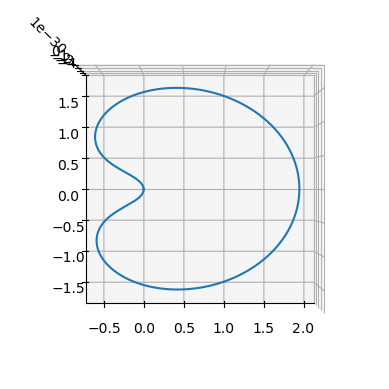

In [15]:
ax = pk.plot.make_3Daxis()
ax.plot(sol[:,0], sol[:,1], sol[:,2])
ax.view_init(90,-90)

We now select two points along the orbit, which we will use as defining bits of our ZOH leg.

In [16]:
ts = -period/3
tf = period/5
ta_cr3bp.pars[:4] = [0,0,0,0] # No thrust
ta_cr3bp.propagate_until(tf, 1000)
xf = ta_cr3bp.state.copy()
ta_cr3bp.propagate_until(ts, 1000)
xs = ta_cr3bp.state.copy()

And we visualize them:

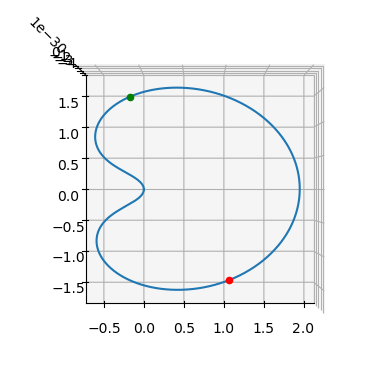

In [17]:
ax = pk.plot.make_3Daxis()
ax.plot(sol[:,0], sol[:,1], sol[:,2])
ax.scatter3D(xs[0], xs[1], xs[2], c='red', s=20)
ax.scatter3D(xf[0], xf[1], xf[2], c='green', s=20)
ax.view_init(90,-90)

We are ready to instantiate our ZOH leg:

In [18]:
# Instantiate the leg
tgrid = np.linspace(ts, tf, nseg + 1)
controls = [0.0, 0.0, 0.0, 0] * nseg # no thrust
leg_cr3bp = pk.leg.zoh(xs, controls, xf, tgrid, cut=cut, tas=[ta_cr3bp, ta_cr3bp_var])
print("The mismatch constraints are: ", leg_cr3bp.compute_mismatch_constraints())

The mismatch constraints are:  [-9.530154443382344e-13, 4.227729277772596e-13, -8.113518108440691e-43, -4.432010314303625e-13, -5.53335155473178e-13, -2.552990639691776e-42, 0.0]


Let us visualize the leg:

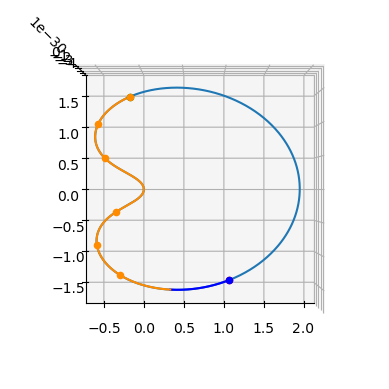

In [19]:
ax = pk.plot.make_3Daxis()
ax.plot(sol[:,0], sol[:,1], sol[:,2])
ax.scatter3D(xs[0], xs[1], xs[2], c='red', s=20)
ax.scatter3D(xf[0], xf[1], xf[2], c='green', s=20)

fwd, bck = leg_cr3bp.get_state_info(N=100)
for segment in fwd:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'blue') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'blue') 
for segment in bck:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'darkorange') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'darkorange') 

ax.view_init(90,-90)

YAY! ... feels like we have achieved something .... 
Let see what happens if we add some non-zero controls ...

In [20]:
# Instantiate the leg
tgrid = np.linspace(ts, tf, nseg + 1)
controls = [0.3, 0.1, 0.1, 0] * nseg # no thrust
leg_cr3bp = pk.leg.zoh(xs, controls, xf, tgrid, cut=cut, tas=[ta_cr3bp, ta_cr3bp_var])
print("The mismatch constraints are: ", leg_cr3bp.compute_mismatch_constraints())

The mismatch constraints are:  [-0.08993581943980528, -0.10164585601023268, -1.3744165273768171e-31, -0.08508397875561213, 0.14503177571385423, 2.7677792705774937e-32, -0.6002422286086804]


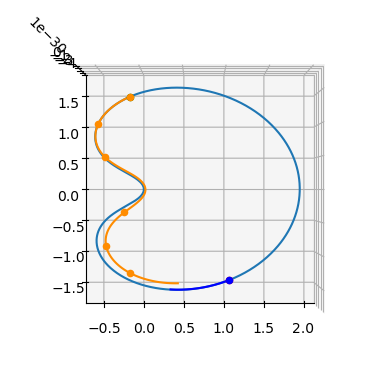

In [21]:
ax = pk.plot.make_3Daxis()
ax.plot(sol[:,0], sol[:,1], sol[:,2])
ax.scatter3D(xs[0], xs[1], xs[2], c='red', s=20)
ax.scatter3D(xf[0], xf[1], xf[2], c='green', s=20)

fwd, bck = leg_cr3bp.get_state_info(N=100)
for segment in fwd:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'blue') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'blue') 
for segment in bck:
    ax.scatter(segment[0,0], segment[0,1], segment[0,2], c = 'darkorange') 
    ax.plot(segment[:,0], segment[:,1], segment[:,2], c= 'darkorange') 

ax.view_init(90,-90)

Makes sense ....